In [1]:
import keras
import os 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding 

C:\Users\HP-1\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import preprocessing
maxlen=500  #Only the first 500 words of sentence is used

In [3]:
bbc_dir = 'E:/ML data/bbc-fulltext/bbc'
labels = []
texts = []
label_count = 0
for label_type in ['business', 'entertainment','politics','sport','tech']:
    dir_name = os.path.join(bbc_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),errors='ignore')
            texts.append(f.read())
            f.close()
            labels.append(label_count)
    label_count = label_count + 1

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
training_samples = 1500  # We will be training on 1500 samples
validation_samples = 500  # We will be validating on 500 samples
test_samples = 225 #We will be testing on 200 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [5]:
from keras.utils import to_categorical
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data=texts
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_train=pd.get_dummies(y_train,)
y_val=pd.get_dummies(y_val)
y_test=to_categorical(y_test)

Found 32360 unique tokens.
Shape of data tensor: (2225, 500)
Shape of label tensor: (2225,)


In [6]:
glove_dir='C:/Users/HP-1/Downloads/glove.6B'
embeddings_index={}
f=open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()
print('Found %s word vectors.'% len(embeddings_index) )

Found 400000 word vectors.


In [7]:
embedding_dim=100
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i<max_words:
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [8]:
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout
model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,kernel_initializer='he_normal',activation='relu'))
model.add(Dense(32,kernel_initializer='he_normal',activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 2,601,253
Trainable params: 2,601,253
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_val, y_val), shuffle=True)

Train on 1500 samples, validate on 500 samples
Epoch 1/40
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1343 - categorical_accuracy: 0.9753 - val_loss: 0.9155 - val_categorical_accuracy: 0.8300
Epoch 2/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1059 - categorical_accuracy: 0.9833 - val_loss: 0.8318 - val_categorical_accuracy: 0.8240
Epoch 3/40
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1002 - categorical_accuracy: 0.9833 - val_loss: 0.9805 - val_categorical_accuracy: 0.7980
Epoch 4/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1167 - categorical_accuracy: 0.9740 - val_loss: 0.6886 - val_categorical_accuracy: 0.8540
Epoch 5/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1214 - categorical_accuracy: 0.9760 - val_loss: 0.6480 - val_categorical_accuracy: 0.8560
Epoch 6/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0857 - categorical_accuracy: 0.989

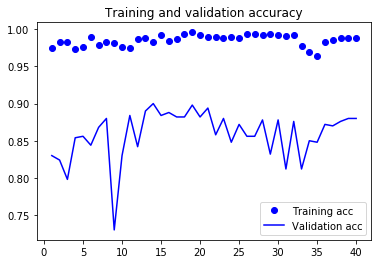

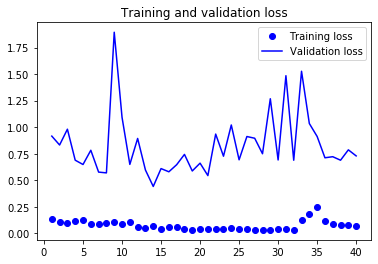

In [11]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
from keras.layers import SimpleRNN
from keras.layers import Embedding,SimpleRNN
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(SimpleRNN(32,return_sequences=True))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 500, 32)           4256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 80005     
Total params: 1,084,261
Trainable params: 1,084,261
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_val, y_val), shuffle=True)

Train on 1500 samples, validate on 500 samples
Epoch 1/40
1500/1500 [==============================] - 10s 7ms/step - loss: 0.9200 - categorical_accuracy: 0.6673 - val_loss: 0.3404 - val_categorical_accuracy: 0.8800
Epoch 2/40
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0772 - categorical_accuracy: 0.9873 - val_loss: 0.2361 - val_categorical_accuracy: 0.9160
Epoch 3/40
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0252 - categorical_accuracy: 0.9993 - val_loss: 0.2101 - val_categorical_accuracy: 0.9240
Epoch 4/40
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0128 - categorical_accuracy: 1.0000 - val_loss: 0.1951 - val_categorical_accuracy: 0.9240
Epoch 5/40
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0085 - categorical_accuracy: 1.0000 - val_loss: 0.1861 - val_categorical_accuracy: 0.9300
Epoch 6/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0062 - categorical_accuracy: 1.

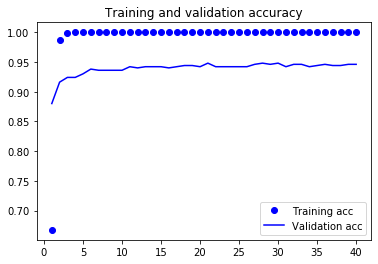

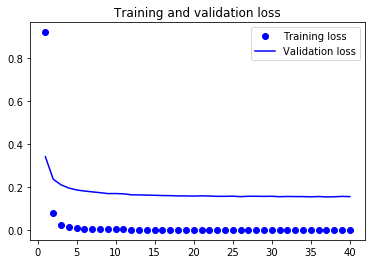

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(LSTM(32,return_sequences=True))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 32)           17024     
_________________________________________________________________
flatten_3 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 80005     
Total params: 1,097,029
Trainable params: 1,097,029
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), shuffle=True)

Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 33s 22ms/step - loss: 0.6998 - categorical_accuracy: 0.7320 - val_loss: 0.4370 - val_categorical_accuracy: 0.8620
Epoch 2/20
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1437 - categorical_accuracy: 0.9540 - val_loss: 0.2403 - val_categorical_accuracy: 0.9180
Epoch 3/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.0762 - categorical_accuracy: 0.9727 - val_loss: 0.1405 - val_categorical_accuracy: 0.9520
Epoch 4/20
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0255 - categorical_accuracy: 0.9933 - val_loss: 0.1387 - val_categorical_accuracy: 0.9540
Epoch 5/20
1500/1500 [==============================] - 31s 21ms/step - loss: 0.0103 - categorical_accuracy: 1.0000 - val_loss: 0.1502 - val_categorical_accuracy: 0.9580
Epoch 6/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0066 - categorical_accu

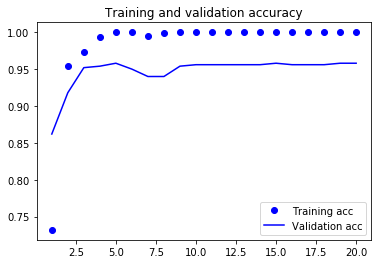

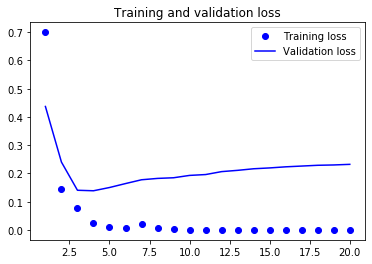

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
from keras.layers import GRU
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(GRU(32,dropout=0.3,recurrent_dropout=0.3,return_sequences=True))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 32)           12768     
_________________________________________________________________
flatten_4 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 80005     
Total params: 1,092,773
Trainable params: 1,092,773
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), shuffle=True)

Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 29s 19ms/step - loss: 1.2296 - categorical_accuracy: 0.5353 - val_loss: 0.4387 - val_categorical_accuracy: 0.8860
Epoch 2/20
1500/1500 [==============================] - 25s 17ms/step - loss: 0.3978 - categorical_accuracy: 0.8640 - val_loss: 0.2280 - val_categorical_accuracy: 0.9280
Epoch 3/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.1938 - categorical_accuracy: 0.9413 - val_loss: 0.1794 - val_categorical_accuracy: 0.9400
Epoch 4/20
1500/1500 [==============================] - 22s 14ms/step - loss: 0.1153 - categorical_accuracy: 0.9673 - val_loss: 0.1743 - val_categorical_accuracy: 0.9500
Epoch 5/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0862 - categorical_accuracy: 0.9760 - val_loss: 0.1478 - val_categorical_accuracy: 0.9560
Epoch 6/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0559 - categorical_accu

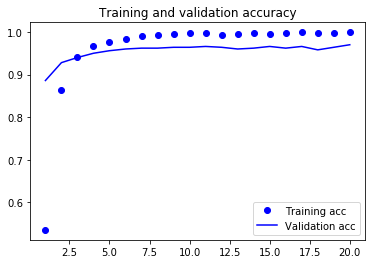

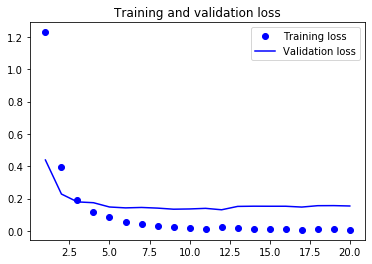

In [20]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           34048     
_________________________________________________________________
flatten_5 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 160005    
Total params: 1,194,053
Trainable params: 1,194,053
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), shuffle=True)

Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.6902 - categorical_accuracy: 0.7680 - val_loss: 0.2067 - val_categorical_accuracy: 0.9280
Epoch 2/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0929 - categorical_accuracy: 0.9680 - val_loss: 0.1909 - val_categorical_accuracy: 0.9420
Epoch 3/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0301 - categorical_accuracy: 0.9947 - val_loss: 0.1633 - val_categorical_accuracy: 0.9400
Epoch 4/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0105 - categorical_accuracy: 1.0000 - val_loss: 0.1578 - val_categorical_accuracy: 0.9540
Epoch 5/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0046 - categorical_accuracy: 1.0000 - val_loss: 0.1813 - val_categorical_accuracy: 0.9480
Epoch 6/20
1500/1500 [==============================] - 35s 24ms/step - loss: 0.0022 - categorical_accu

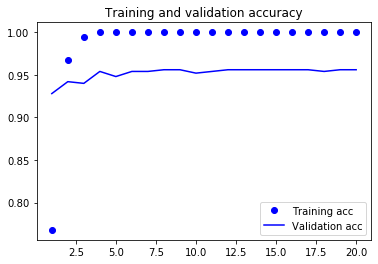

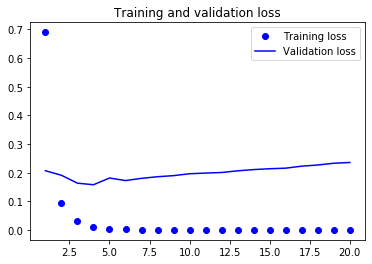

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()